In [2]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from DS3Dplus.ds3d_utils import ImModel
from torch import nn
from numpy import pi
import torch.fft as fft
import torch.nn.functional as F
from skimage import io

from misc import Zernike_basis_numpy

In [3]:
def param_set():
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    im_param_dict = dict(
        device=device,
        # oil objective
        M=100,  # magnification
        NA=1.45,  # NA
        n_immersion=1.518,  # refractive index of the immersion of the objective

        # optics
        lamda=0.67,  # wavelength
        n_sample=1.33,  # refractive index of the sample
        f_4f=100e3,  # focal length of 4f system
        ps_camera=11,  # pixel size of the camera
        ps_BFP=30,  # pixel size at back focal plane
        NFP=0.7,  # location of the nominal focal plane
        phase_mask=None,

        # image
        H=15,  # FOV/im size, odd
        W=15,  # FOV/im size, odd
        g_size=9,  # size of the gaussian blur kernel
        g_sigma=[0.9, 1.0],  # std of the gaussian blur kernel
        bg=10,  # background
        baseline=[0, 0],
        read_std=[0, 0],  # standard deviation of readout noise
    )
    
    zer = Zernike_basis_numpy(89, 203, 4)
    phase_mask = -zer[:, :, 5]
    im_param_dict['phase_mask'] = phase_mask
    
    param_dict = {**im_param_dict}

    return param_dict



class ImModel_in_situ(ImModel):
    def __init__(self, params):
        super().__init__(params)
        self.g_sigma = (self.g_sigma[0]+self.g_sigma[1])/4
        
    def forward(self, phase_mask, xyzs, photons, bg):
        phase_lateral = self.Xgrid * (xyzs[:, 0:1].unsqueeze(1)) + self.Ygrid * (xyzs[:, 1:2].unsqueeze(1))
        phase_axial = self.Zgrid * (xyzs[:, 2:3].unsqueeze(1)) + self.phase_NFP
        
        ef_bfp = self.circ * torch.exp(1j * (phase_axial + phase_lateral + phase_mask))
        psf_field = fft.fftshift(fft.fftn(fft.ifftshift(ef_bfp, dim=(1, 2)), dim=(1, 2)), dim=(1, 2))  # FT
        psfs = torch.abs(psf_field)** 2

        # blur
        blur_kernel = 1 / (2 * pi * self.g_sigma ** 2) * (
            torch.exp(-0.5 * (self.g_xx ** 2 + self.g_yy ** 2) / self.g_sigma ** 2))
        psfs = F.conv2d(psfs.unsqueeze(1), blur_kernel.unsqueeze(0).unsqueeze(0), padding='same')
        psfs = psfs.squeeze(1) 
        
        # photon normalization
        psfs = psfs / torch.sum(psfs, dim=(1, 2), keepdims=True) * photons.unsqueeze(1) + bg.unsqueeze(1)  # photon normalization
        psfs = psfs[:, self.r0:self.r0 + self.H, self.c0:self.c0 + self.W]
        
        return psfs



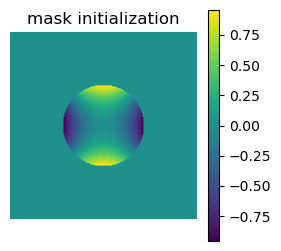

In [4]:
param_dict = param_set()
device = param_dict['device']

model = ImModel(param_dict)

# test the imaging model
# xyzp_test = np.array([[0.0, 0.0, 1.0, 1e4]])
# psf_test = model(torch.from_numpy(xyzp_test).to(device)).cpu().numpy()

# plt.figure(figsize=(6, 3))
# plt.subplot(1, 2, 1)
# plt.imshow(param_dict['phase_mask'])
# plt.title('ground truth mask')
# plt.colorbar()
# plt.axis('off')
# plt.subplot(1, 2, 2)
# plt.imshow(psf_test)
# plt.axis('off')
# plt.show()


# # phase mask for initialization
# mask_dict = sio.loadmat('./DS3D/mask_tetra_model_resize.mat')
# mask_name = list(mask_dict.keys())[3]

phase_mask2 = param_dict['phase_mask']

plt.figure(figsize=(3, 3))
plt.imshow(phase_mask2)
plt.axis('off')
plt.colorbar()
plt.title('mask initialization')
plt.show()

In [5]:
model_in_situ = ImModel_in_situ(param_dict)

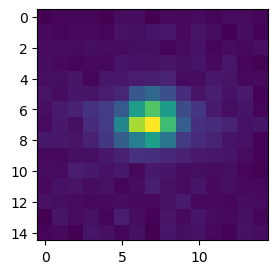

In [14]:
psf_measurement = io.imread(r'./in_situ_data/psfs.tif')
psf_measurement = psf_measurement.astype(np.float32)

psf_test = psf_measurement[0]
plt.figure(figsize=(3, 3))
plt.imshow(psf_test)
plt.show()


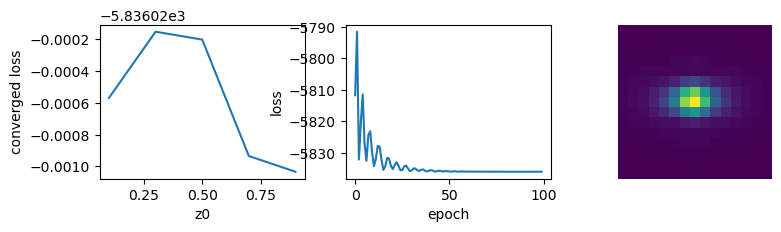

tensor([[-0.0184, -0.0223,  0.7033]]) tensor([[81443.7031]]) tensor([[640.4341]])


In [7]:
# MLE implementation: sensitive to z initialization

mask0 = np.copy(phase_mask2)

y = torch.tensor(psf_test, device=device)

z0_list = [0.1, 0.3, 0.5, 0.7, 0.9]  # initialization options 
loss_list = []
result_list = []
for z0 in z0_list:
    mask_in_situ = torch.tensor(mask0, device=device)
    xyz = torch.tensor([[0, 0, z0]], device=device, requires_grad=True)
    photon = torch.tensor([[8e4]], device=device, requires_grad=True)
    bg = torch.tensor([[600.0]], device=device, requires_grad=True)

    optimizer = torch.optim.Adam([{'params': xyz, 'lr': 0.10},
                                  {'params': photon, 'lr': 1000.0},
                                  {'params': bg, 'lr': 10.0},
                                  ])
    epoch_loss = []
    for ii in range(100):
        fx = model_in_situ(mask_in_situ, xyz, photon, bg)[0]            
        loss = torch.mean(fx-y*torch.log(fx))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        epoch_loss.append(loss.item())
        
    loss_list.append(epoch_loss)
    result_list.append([xyz.detach().cpu(), photon.detach().cpu(), bg.detach().cpu(), fx.detach().cpu()])
    

final_losses = [loss_list[i][-1] for i in range(5)]
min_idx = np.argmin(np.array(final_losses))
final_result = result_list[min_idx]


xyz_hat, photon_hat, bg_hat, y_hat = final_result

plt.figure(figsize=(9, 2))
plt.subplot(1, 3, 1)
plt.plot(z0_list, final_losses)
plt.xlabel('z0')
plt.ylabel('converged loss')

plt.subplot(1, 3, 2)
plt.plot(loss_list[min_idx])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(1, 3, 3)
plt.imshow(final_result[-1])
plt.axis('off')
plt.show()

print(xyz_hat, photon_hat, bg_hat)


In [8]:
mask0 = np.copy(phase_mask2)

# start iterations

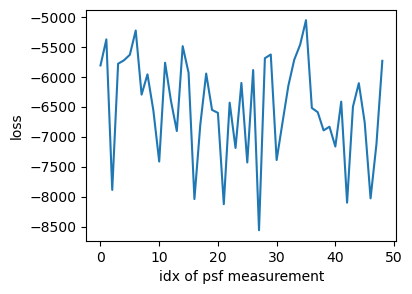

In [9]:
# localization by MLE
nz  = psf_measurement.shape[0]
xyzs = torch.zeros((nz, 3), device=device)
photons = torch.zeros((nz, 1), device=device)
bgs = torch.zeros((nz, 1), device=device)

mle_loss = []

# mask0 = phase_mask2_updated
for i in range(psf_measurement.shape[0]):
    
    y = torch.tensor(psf_measurement[i], device=device)
    
    z0_list = [0.1, 0.3, 0.5, 0.7, 0.9]  # initialization options
    
    loss_list = []
    result_list = []
    
    for z0 in z0_list:
        mask_in_situ = torch.tensor(mask0, device=device)
        xyz = torch.tensor([[0, 0, z0]], device=device, requires_grad=True)
        photon = torch.tensor([[8e4]], device=device, requires_grad=True)
        bg = torch.tensor([[600.0]], device=device, requires_grad=True)

        optimizer = torch.optim.Adam([{'params': xyz, 'lr': 0.20},
                                      {'params': photon, 'lr': 1000.0},
                                      {'params': bg, 'lr': 10.0},
                                      ])
        epoch_loss = []
        for ii in range(100):
            fx = model_in_situ(mask_in_situ, xyz, photon, bg)[0]            
            loss = torch.mean(fx-y*torch.log(fx))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())

        loss_list.append(epoch_loss)
        result_list.append([xyz.detach().cpu(), photon.detach().cpu(), bg.detach().cpu(), fx.detach().cpu()])


    final_losses = [loss_list[i][-1] for i in range(5)]
    min_idx = np.argmin(np.array(final_losses))
    final_result = result_list[min_idx]
    xyz_hat, photon_hat, bg_hat, y_hat = final_result
    
    
    xyzs[i, :] = xyz_hat.to(device)
    photons[i, :] = photon_hat.to(device)
    bgs[i, :] = bg_hat.to(device)
    
    mle_loss.append(epoch_loss[0])
    
# xyzs[:, 2] = (xyzs[:, 2]-torch.min(xyzs[:, 2]))  # constraint: positive axial position

plt.figure(figsize=(4, 3))

plt.plot(mle_loss)
plt.xlabel('idx of psf measurement')
plt.ylabel('loss')
plt.show()

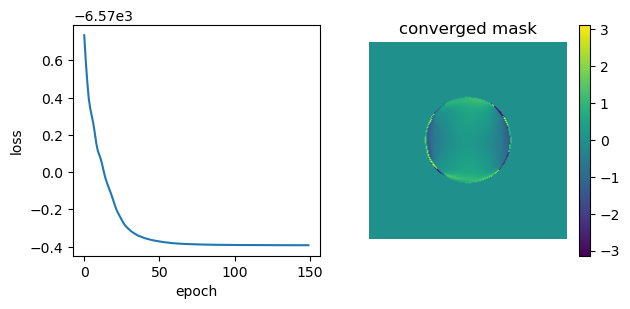

In [10]:
mask_in_situ = torch.tensor(mask0, device=device, requires_grad=True)

optimizer = torch.optim.Adam([{'params': mask_in_situ, 'lr': 0.1},
                              ])

y = torch.tensor(psf_measurement, device=device)

epoch_loss = []
for i in range(150):
    
    fx = model_in_situ(mask_in_situ, xyzs, photons, bgs)            
    loss = torch.mean(fx-y*torch.log(fx))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_loss.append(loss.item())


mask0 = mask_in_situ.detach().cpu().numpy()
mask0 = np.angle(np.exp(1j*mask0))   
    
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.plot(epoch_loss)
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.imshow(mask0)
plt.title('converged mask')
plt.colorbar()
plt.axis('off')
plt.show()

# end iterations

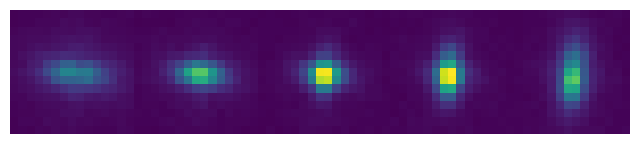

In [15]:
# bead data, nfp varies

psf_bead = io.imread(r'./in_situ_data/astig_-06_06.tif')
psf_bead = psf_bead[::4][1:-1]


ims = [psf_bead[i] for i in range(psf_bead.shape[0])]
psf_bead_ = np.concatenate(ims, axis=1)
plt.figure(figsize=(8, 3))
plt.imshow(psf_bead_)
plt.axis('off')
plt.show()


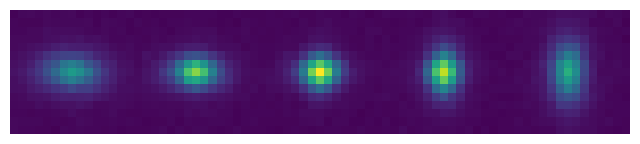

In [12]:
# use the in-situ phase mask to simulate the bead PSFs
model.phase_mask = torch.tensor(mask0, device=device)
model.bg = 100
zs = np.linspace(-0.4, 0.4, 5)
ims = []

for z in zs:
    model.NFP = z
    xyzps = np.array([[0.0, 0.0, 0.0, 4e4]])
    im = model(torch.from_numpy(xyzps).to(device)).cpu().numpy()
    ims.append(im)

ims_init = np.concatenate(ims, axis=1)
plt.figure(figsize=(8, 3))
plt.imshow(ims_init)
plt.axis('off')
plt.show()

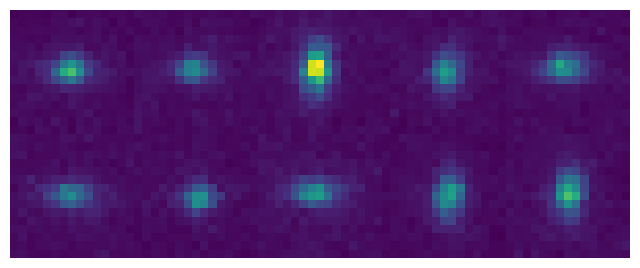

In [13]:
# show some PSFs from blinking data
ims1 = psf_measurement[:5]
ims1 = np.concatenate([ims1[i] for i in range(5)], axis=1)
ims2 = psf_measurement[5:10]
ims2 = np.concatenate([ims2[i] for i in range(5)], axis=1)
ims12 = np.concatenate([ims1, ims2], axis=0)

plt.figure(figsize=(8, 6))
plt.imshow(ims12)
plt.axis('off')
plt.show()

